
# 04 — Monte Carlo Calendar-Arbitrage Check (nearby expiries)

This notebook adds a Monte Carlo based calendar-arbitrage check across two nearby expiries.

What this does
- Simulates GBM paths (risk-neutral) with common random numbers at two nearby maturities T1 < T2 to estimate the calendar spread C(K,T2) - C(K,T1) with lower variance.
- Uses control variates with Black-Scholes analytic prices to reduce variance.
- Reports 95% confidence intervals on the spread to assess if any negative values are statistically significant.
- Scans a strike grid and flags potential calendar-arb violations (i.e., C(K,T2) < C(K,T1) beyond tolerance/CI).
- Optional smoothing: a tiny enforcement step to make C(K,T) non-decreasing in T for each K, if desired.


    K   C(K,T1)   C(K,T2)   Spread   CI low  CI high
 70.0 30.528360 30.550435 0.022053 0.021158 0.022948
 80.0 20.740262 20.779703 0.039420 0.038574 0.040265
 90.0 11.850264 11.933943 0.083662 0.082948 0.084376
 95.0  8.217215  8.321509 0.104279 0.103624 0.104934
100.0  5.342054  5.454812 0.112744 0.112109 0.113379
105.0  3.251470  3.357639 0.106157 0.105509 0.106805
110.0  1.855137  1.943290 0.088143 0.087486 0.088800
120.0  0.502789  0.546661 0.043866 0.043289 0.044442
130.0  0.109048  0.124508 0.015458 0.015055 0.015862
Potential calendar-arb violations (95% CI): []


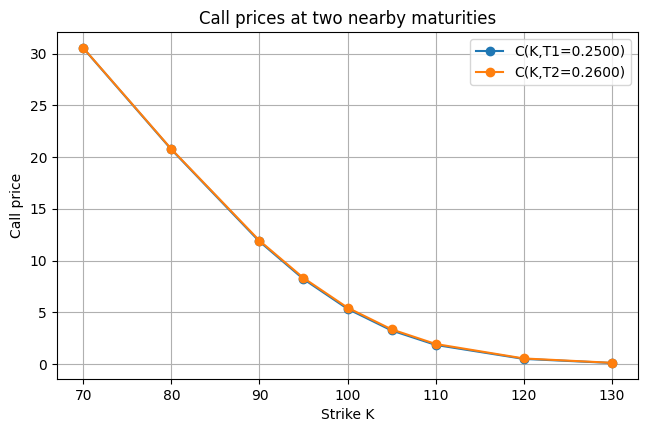

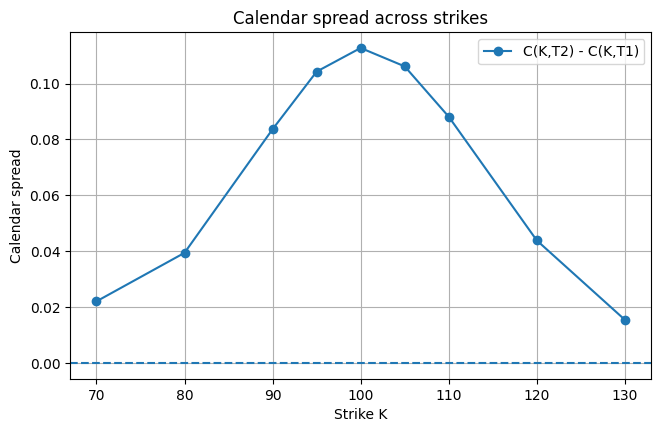

C(100.00,0.2500) = 5.339744  (+/- 0.011565)
C(100.00,0.2600) = 5.452458  (+/- 0.011789)
Spread = 0.112678  95% CI [0.112129, 0.113227]


In [1]:

import numpy as np
import math
from dataclasses import dataclass
from typing import Optional, Dict, List
import matplotlib.pyplot as plt

# Reproducibility
rng = np.random.default_rng(42)
plt.rcParams["figure.figsize"] = (7.5, 4.5)
plt.rcParams["axes.grid"] = True

def _phi(x: float) -> float:
    return 0.5 * (1.0 + math.erf(x / math.sqrt(2.0)))

def bs_call_price(S0: float, K: float, T: float, r: float, q: float, sigma: float) -> float:
    # Black-Scholes European call (continuous carry q)
    if T <= 0:
        return max(S0 - K, 0.0)
    if sigma <= 0:
        fwd = S0 * math.exp((r - q) * T)
        disc = math.exp(-r * T)
        return max(disc * (fwd - K), 0.0)
    sqrtT = math.sqrt(T)
    d1 = (math.log(S0 / K) + (r - q + 0.5 * sigma * sigma) * T) / (sigma * sqrtT)
    d2 = d1 - sigma * sqrtT
    disc_r = math.exp(-r * T)
    disc_q = math.exp(-q * T)
    return disc_q * S0 * _phi(d1) - disc_r * K * _phi(d2)

def simulate_terminal(S0: float, r: float, q: float, sigma: float, T: float, Z: np.ndarray) -> np.ndarray:
    # Exact simulation of GBM terminal S_T using a single normal Z per path
    if T <= 0:
        return np.full_like(Z, S0, dtype=float)
    mu = (r - q - 0.5 * sigma**2) * T
    sd = sigma * math.sqrt(T)
    return S0 * np.exp(mu + sd * Z)

@dataclass
class MCEstimate:
    price: float
    stderr: float
    ci_low: float
    ci_high: float
    n_paths: int

def mc_call_with_cv(S0: float, K: float, T: float, r: float, q: float, sigma: float, Z: np.ndarray) -> MCEstimate:
    # Monte Carlo call price using control variate: E[ST] as control with known mean
    if T <= 0:
        payoff = np.maximum(S0 - K, 0.0)
        return MCEstimate(payoff, 0.0, payoff, payoff, len(Z))

    ST = simulate_terminal(S0, r, q, sigma, T, Z)
    disc = math.exp(-r * T)
    payoff = np.maximum(ST - K, 0.0)

    proxy = ST
    proxy_mean = S0 * math.exp((r - q) * T)
    Y = disc * payoff
    X = proxy

    cov = float(np.cov(Y, X, ddof=1)[0,1])
    varX = float(np.var(X, ddof=1))
    beta = 0.0 if varX == 0 else cov / varX

    est_vec = Y - beta * (X - proxy_mean)
    mean = float(np.mean(est_vec))
    sd = float(np.std(est_vec, ddof=1))
    n = len(Z)
    stderr = sd / math.sqrt(n)
    ci_low = mean - 1.96 * stderr
    ci_high = mean + 1.96 * stderr
    return MCEstimate(mean, stderr, ci_low, ci_high, n)

from dataclasses import dataclass
@dataclass
class SpreadEstimate:
    spread: float
    stderr: float
    ci_low: float
    ci_high: float
    n_paths: int

def mc_calendar_spread(S0: float, K: float, T1: float, T2: float, r: float, q: float, sigma: float,
                       n_paths: int = 200_000, antithetic: bool = True, rng_seed: Optional[int] = 42):
    # Estimate C(K,T2) - C(K,T1) with common random numbers and optional antithetics
    assert T2 > T1 >= 0, "Require 0 <= T1 < T2."

    rng = np.random.default_rng(rng_seed)
    Z = rng.standard_normal(n_paths)
    if antithetic:
        Z = np.concatenate([Z, -Z])

    est1 = mc_call_with_cv(S0, K, T1, r, q, sigma, Z)
    est2 = mc_call_with_cv(S0, K, T2, r, q, sigma, Z)

    ST1 = simulate_terminal(S0, r, q, sigma, T1, Z)
    ST2 = simulate_terminal(S0, r, q, sigma, T2, Z)
    Y1 = np.exp(-r*T1) * np.maximum(ST1 - K, 0.0)
    Y2 = np.exp(-r*T2) * np.maximum(ST2 - K, 0.0)

    D = Y2 - Y1
    mean = float(np.mean(D))
    sd = float(np.std(D, ddof=1))
    n = len(D)
    stderr = sd / math.sqrt(n)
    ci_low = mean - 1.96 * stderr
    ci_high = mean + 1.96 * stderr

    spread_est = SpreadEstimate(mean, stderr, ci_low, ci_high, n)
    return est1, est2, spread_est

def scan_strikes_calendar(S0: float, strikes: np.ndarray, T1: float, T2: float, r: float, q: float, sigma: float,
                          n_paths: int = 200_000, antithetic: bool = True, rng_seed: Optional[int] = 42,
                          report: bool = True):
    # For each K in strikes, MC estimate of C(K,T1), C(K,T2) and the spread
    out = {}
    rows = []
    for K in strikes:
        est1, est2, spread = mc_calendar_spread(
            S0, float(K), T1, T2, r, q, sigma, n_paths=n_paths, antithetic=antithetic, rng_seed=rng_seed
        )
        out[float(K)] = {
            "C_T1": est1.price, "C_T2": est2.price, "Spread": spread.spread,
            "Spread_ci_low": spread.ci_low, "Spread_ci_high": spread.ci_high,
            "stderr": spread.stderr
        }
        rows.append([K, est1.price, est2.price, spread.spread, spread.ci_low, spread.ci_high])

    if report:
        import pandas as pd
        df = pd.DataFrame(rows, columns=["K", "C(K,T1)", "C(K,T2)", "Spread", "CI low", "CI high"])
        try:
            from caas_jupyter_tools import display_dataframe_to_user
            display_dataframe_to_user("Calendar-Spread Monte Carlo (per strike)", df)
        except Exception:
            print(df.to_string(index=False))
    return out

def calendar_violations(results: Dict[float, Dict[str, float]], tol: float = 0.0, use_ci: bool = True):
    # Identify violations where C(K,T2) < C(K,T1).
    viols = []
    for K, m in results.items():
        spread = m["Spread"]
        ci_low = m["Spread_ci_low"]
        ci_high = m["Spread_ci_high"]
        if use_ci:
            if ci_high < -tol:
                viols.append({"K": K, "Spread": spread, "CI low": ci_low, "CI high": ci_high})
        else:
            if spread < -tol:
                viols.append({"K": K, "Spread": spread, "CI low": ci_low, "CI high": ci_high})
    return viols

def enforce_monotone_in_T(C_T1: float, C_T2: float, eps: float = 1e-8):
    # Enforce C(T2) >= C(T1) up to a small epsilon by minimally raising C(T2)
    if C_T2 + eps < C_T1:
        return C_T1, C_T1 + eps
    return C_T1, C_T2

# Demo parameters (edit as desired)
S0   = 100.0
r    = 0.03
q    = 0.00
sigma= 0.25
T1 = 0.25
T2 = 0.26
strikes = np.array([70, 80, 90, 95, 100, 105, 110, 120, 130], dtype=float)

N_PATHS = 150_000
ANTITHETIC = True
SEED = 7

results = scan_strikes_calendar(
    S0, strikes, T1, T2, r, q, sigma,
    n_paths=N_PATHS, antithetic=ANTITHETIC, rng_seed=SEED, report=True
)

violations = calendar_violations(results, tol=0.0, use_ci=True)
print("Potential calendar-arb violations (95% CI):", violations)

# Visualization
Ks = np.array(sorted(results.keys()), dtype=float)
C1 = np.array([results[k]["C_T1"] for k in Ks])
C2 = np.array([results[k]["C_T2"] for k in Ks])
Sp = np.array([results[k]["Spread"] for k in Ks])

fig = plt.figure()
plt.plot(Ks, C1, marker='o', label=f"C(K,T1={T1:.4f})")
plt.plot(Ks, C2, marker='o', label=f"C(K,T2={T2:.4f})")
plt.xlabel("Strike K")
plt.ylabel("Call price")
plt.title("Call prices at two nearby maturities")
plt.legend()
plt.show()

fig = plt.figure()
plt.plot(Ks, Sp, marker='o', label="C(K,T2) - C(K,T1)")
plt.axhline(0.0, linestyle='--')
plt.xlabel("Strike K")
plt.ylabel("Calendar spread")
plt.title("Calendar spread across strikes")
plt.legend()
plt.show()

# Convenience spot check
def spot_check(S0=100.0, K=100.0, T1=0.25, T2=0.26, r=0.03, q=0.00, sigma=0.25,
               n_paths=200_000, antithetic=True, seed=42):
    est1, est2, sp = mc_calendar_spread(S0, K, T1, T2, r, q, sigma, n_paths, antithetic, seed)
    print(f"C({K:.2f},{T1:.4f}) = {est1.price:.6f}  (+/- {1.96*est1.stderr:.6f})")
    print(f"C({K:.2f},{T2:.4f}) = {est2.price:.6f}  (+/- {1.96*est2.stderr:.6f})")
    print(f"Spread = {sp.spread:.6f}  95% CI [{sp.ci_low:.6f}, {sp.ci_high:.6f}]")
    return est1, est2, sp

_ = spot_check(K=100.0, T1=T1, T2=T2, sigma=sigma, seed=SEED)
